# Image Classification Pipeline for "Museum-Indoor vs. Museum-Outdoor" images using both Supervised and Semi-Supervised Learning.

# ==========================
# 1. Import Libraries
# ==========================

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil
import gc
import platform

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


# ==========================
# 2. Load and Preprocess Data
# ==========================

In [3]:
# ==========================
# 1. Load and Preprocess Data
# ==========================

# Main Execution
base_dir = 'Dataset'
# Constants
IMG_SIZE = (64, 64)
CLASSES = ['museum-indoor', 'museum-outdoor']

# Load Images and Labels
def load_images_and_labels(base_dir):
    images, labels = [], []
    for label, cls in enumerate(CLASSES):
        folder_path = os.path.join(base_dir, cls)
        for img_name in os.listdir(folder_path):
            img = cv2.imread(os.path.join(folder_path, img_name))
            img = cv2.resize(img, IMG_SIZE)
            images.append(img.flatten())
            labels.append(label)
    return np.array(images), np.array(labels)

In [4]:
X, y = load_images_and_labels(base_dir)
X = X / 255.0  # normalization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# ==========================
# 3. Descriptive Analysis (EDA)
# ==========================

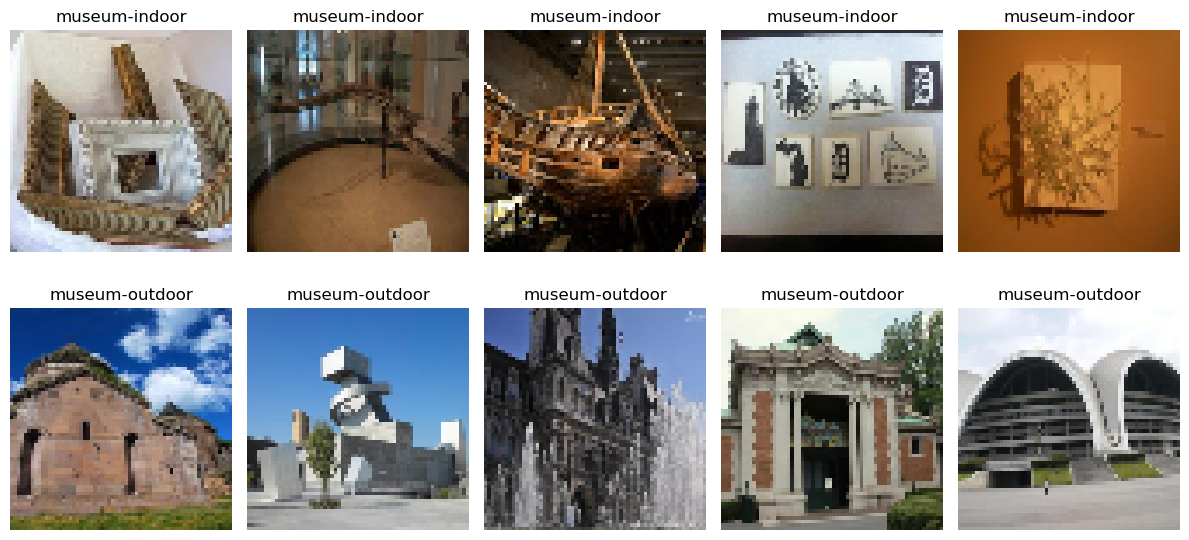

In [6]:
# Display Sample Images
def display_sample_images(base_dir):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for label, cls in enumerate(CLASSES):
        folder_path = os.path.join(base_dir, cls)
        sample_images = os.listdir(folder_path)[:5]
        for i, img_name in enumerate(sample_images):
            img = cv2.imread(os.path.join(folder_path, img_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[label, i].imshow(cv2.resize(img, IMG_SIZE))
            axes[label, i].set_title(f'{cls}')
            axes[label, i].axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images(base_dir)

# =============================
# 4. Supervised Models Training
# =============================

In [10]:
# Profiling Function (Time + Memory)
def profile_model(model, X_train, y_train, X_test, y_test, model_name):
    gc.collect()
    process = psutil.Process()
    mem_before = process.memory_info().rss / 1024 / 1024

    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = time.time()
    
    mem_after = process.memory_info().rss / 1024 / 1024

    print(f"\n=== {model_name} Performance ===")
    print(classification_report(y_test, y_pred, target_names=CLASSES))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Time (s)": end_time - start_time,
        "Memory (MB)": mem_after - mem_before
    }


## 4.1 Decision Tree


=== Decision Tree Performance ===
                precision    recall  f1-score   support

 museum-indoor       0.83      0.84      0.83       750
museum-outdoor       0.83      0.83      0.83       750

      accuracy                           0.83      1500
     macro avg       0.83      0.83      0.83      1500
  weighted avg       0.83      0.83      0.83      1500



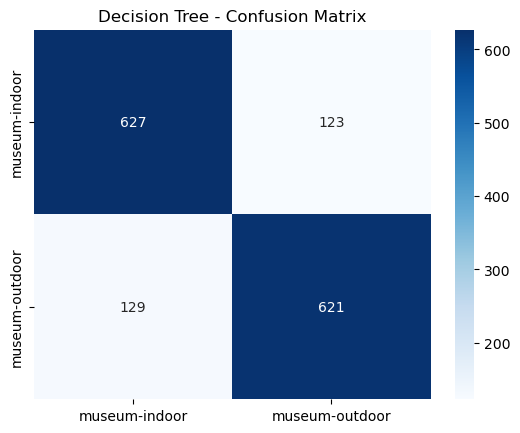

In [12]:
# Decision Tree
dt = DecisionTreeClassifier(max_depth=10)
dt_metrics = profile_model(dt, X_train, y_train, X_test, y_test, "Decision Tree")

## 4.2 Random Forest


=== Random Forest Performance ===
                precision    recall  f1-score   support

 museum-indoor       0.88      0.92      0.90       750
museum-outdoor       0.91      0.87      0.89       750

      accuracy                           0.90      1500
     macro avg       0.90      0.90      0.90      1500
  weighted avg       0.90      0.90      0.90      1500



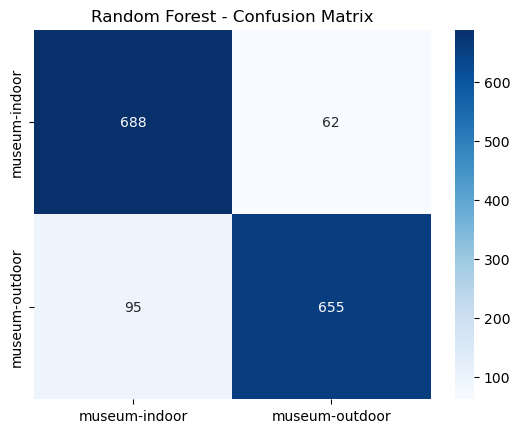

In [16]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=20)
rf_metrics = profile_model(rf, X_train, y_train, X_test, y_test, "Random Forest")

## 4.3 XGBoost


=== XGBoost Performance ===
                precision    recall  f1-score   support

 museum-indoor       0.89      0.92      0.90       750
museum-outdoor       0.92      0.88      0.90       750

      accuracy                           0.90      1500
     macro avg       0.90      0.90      0.90      1500
  weighted avg       0.90      0.90      0.90      1500



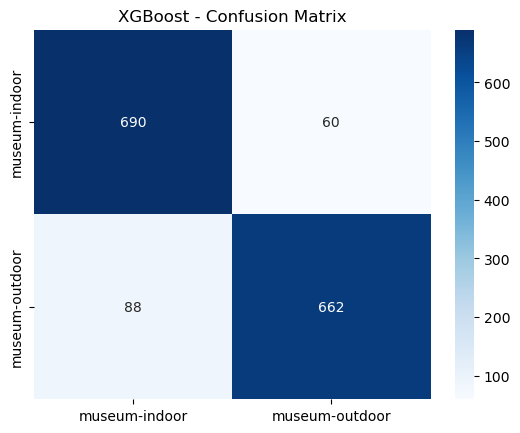

In [23]:
# XGBoost
xgb = XGBClassifier()
xgb_metrics = profile_model(xgb, X_train, y_train, X_test, y_test, "XGBoost")

# ==========================
# 5. Semi-Supervised Learning (Pseudo-Labeling)
# ==========================

Iteration 1: Labeled = 8403, Unlabeled = 97
Iteration 2: Labeled = 8422, Unlabeled = 78
No confident pseudo-labels found in iteration 3. Stopping.

=== Semi-Supervised Decision Tree Performance ===
                precision    recall  f1-score   support

 museum-indoor       0.81      0.79      0.80       750
museum-outdoor       0.79      0.81      0.80       750

      accuracy                           0.80      1500
     macro avg       0.80      0.80      0.80      1500
  weighted avg       0.80      0.80      0.80      1500



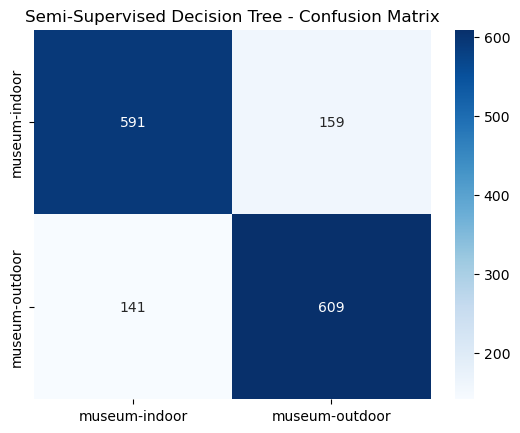

In [25]:
def semi_supervised_training(X_train, y_train, X_test, y_test):
    # Split into 20% labeled, 80% unlabeled
    X_train_labeled, X_train_unlabeled, y_train_labeled, y_train_unlabeled = train_test_split(
        X_train, y_train, train_size=0.2, stratify=y_train, random_state=42
    )

    semi_model = DecisionTreeClassifier(max_depth=10)

    gc.collect()
    process = psutil.Process()
    mem_before = process.memory_info().rss / 1024 / 1024
    start_time = time.time()

    # Semi-supervised loop for 5 iterations
    for iteration in range(5):
        if len(X_train_unlabeled) == 0:
            print(f"Stopping early after {iteration} iterations - no more unlabeled data.")
            break

        # Train on labeled data
        semi_model.fit(X_train_labeled, y_train_labeled)

        # Predict on remaining unlabeled data
        probs = semi_model.predict_proba(X_train_unlabeled)
        pseudo_labels = np.argmax(probs, axis=1)
        confidences = np.max(probs, axis=1)

        # Set confidence threshold (you can adjust this)
        confident_indices = (confidences >= 0.85)

        # Skip if no confident samples
        if np.sum(confident_indices) == 0:
            print(f"No confident pseudo-labels found in iteration {iteration + 1}. Stopping.")
            break

        # Add confident samples to the labeled pool
        X_confident = X_train_unlabeled[confident_indices]
        y_confident = pseudo_labels[confident_indices]

        X_train_labeled = np.concatenate([X_train_labeled, X_confident])
        y_train_labeled = np.concatenate([y_train_labeled, y_confident])

        # Remove confident samples from the unlabeled pool
        X_train_unlabeled = X_train_unlabeled[~confident_indices]

        gc.collect()  # Clean up memory between iterations
        print(f"Iteration {iteration+1}: Labeled = {len(X_train_labeled)}, Unlabeled = {len(X_train_unlabeled)}")

    end_time = time.time()
    mem_after = process.memory_info().rss / 1024 / 1024

    # Final evaluation on test set
    y_pred = semi_model.predict(X_test)

    print(f"\n=== Semi-Supervised Decision Tree Performance ===")
    print(classification_report(y_test, y_pred, target_names=CLASSES))

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title('Semi-Supervised Decision Tree - Confusion Matrix')
    plt.show()

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "Time (s)": end_time - start_time,
        "Memory (MB)": mem_after - mem_before
    }


# Semi-Supervised Decision Tree
semi_metrics = semi_supervised_training(X_train, y_train, X_test, y_test)

In [29]:
from joblib import dump
import os

# Create 'models' directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# After training each model, save it to 'models' folder
dump(dt, 'models/decision_tree_model.joblib')
dump(rf, 'models/random_forest_model.joblib')
dump(xgb, 'models/xgboost_model.joblib')

print("✅ All models saved successfully in 'models' folder.")


✅ All models saved successfully in 'models' folder.


# ==========================
# 6. Final Summary Table
# ==========================

In [32]:
# Final Comparison Table
import pandas as pd

final_metrics = pd.DataFrame({
    "Decision Tree": dt_metrics,
    "Random Forest": rf_metrics,
    "XGBoost": xgb_metrics,
    "Semi-Supervised DT": semi_metrics
}).T

print("\n=== Final Model Comparison ===")

# Drop Memory column
final_metrics = final_metrics.drop(columns=["Memory (MB)"])

# Round numeric columns to two decimal places
final_metrics = final_metrics.round(2)

final_metrics


=== Final Model Comparison ===


,Accuracy,Precision,Recall,F1 Score,Time (s)
Decision Tree,0.83,0.83,0.83,0.83,132.53
Random Forest,0.90,0.91,0.87,0.89,107.96
XGBoost,0.90,0.92,0.88,0.90,487.91
Semi-Supervised DT,0.80,0.80,0.80,0.80,216.33


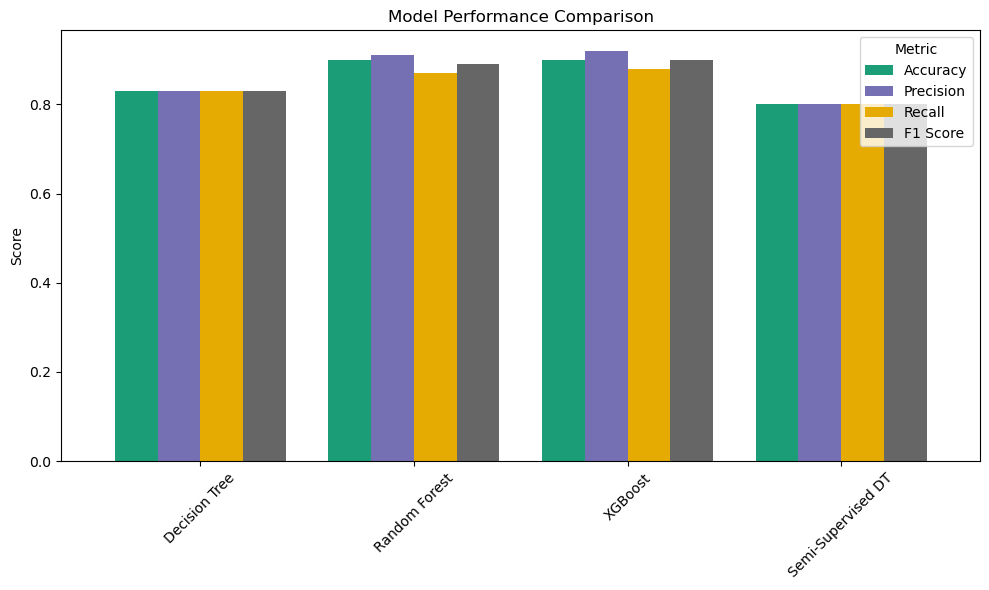

In [34]:

import matplotlib.pyplot as plt

# Drop 'Time (s)' since we only want the performance metrics
metrics_to_plot = final_metrics.drop(columns=['Time (s)'])

# Plot grouped bar chart
metrics_to_plot.plot(kind='bar', figsize=(10, 6), colormap='Dark2', width=0.8)

# Customize plot
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric')

# Show plot
plt.tight_layout()
plt.show()


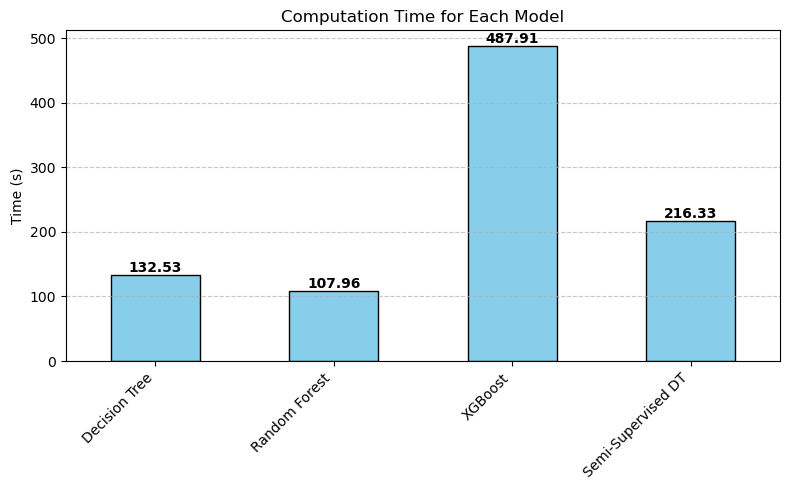

In [36]:
import matplotlib.pyplot as plt

# Extract 'Time (s)' column for plotting
time_usage = final_metrics['Time (s)']

# Plot bar chart
plt.figure(figsize=(8, 5))
time_usage.plot(kind='bar', color='skyblue', edgecolor='black')

# Customize plot
plt.title('Computation Time for Each Model')
plt.ylabel('Time (s)')
plt.xticks(range(len(time_usage)), final_metrics.index, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add time values on top of bars
for i, v in enumerate(time_usage):
    plt.text(i, v + 5, f'{v:.2f}', ha='center', fontsize=10, fontweight='bold')

# Show plot
plt.tight_layout()
plt.show()


In [38]:
# System Info
def system_info():
    print("\n=== System Information ===")
    print(f"Platform: {platform.system()} {platform.release()}")
    print(f"Processor: {platform.processor()}")
    if hasattr(psutil, 'virtual_memory'):
        print(f"RAM: {psutil.virtual_memory().total / 1024 / 1024:.2f} MB")

# System Info
system_info()


=== System Information ===
Platform: Windows 11
Processor: Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
RAM: 8053.61 MB


In [44]:
from joblib import load
import cv2

def predict_new_image(image_path, model_path):
    loaded_model = load(model_path)

    # Preprocess
    img = cv2.imread(image_path)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img_flattened = img.flatten().reshape(1, -1)

    # Predict
    predicted_label = loaded_model.predict(img_flattened)[0]
    print(f"Predicted Class: {CLASSES[predicted_label]}")

    # Optionally show confidence
    probs = loaded_model.predict_proba(img_flattened)[0]
    for cls, prob in zip(CLASSES, probs):
        print(f" Confidence {cls}: {prob:.2%}")

predict_new_image('test.jpg', 'models/random_forest_model.joblib')


Predicted Class: museum-outdoor
 Confidence museum-indoor: 0.27%
 Confidence museum-outdoor: 99.73%
